In [1]:
import os
# force CPU for inference
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.models import load_model
import pandas as pd
import keras.backend as K
from keras.callbacks import LearningRateScheduler
from keras.callbacks import Callback
import math
import numpy as np
import matplotlib.pyplot as plt

def coeff_r2(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model = load_model('4_Block_Nets/FPV_ANN_tabulated_Standard_500.H5')
# model = load_model('../tmp/calc_100_3_3_cbrt.h5', custom_objects={'coeff_r2':coeff_r2})
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3)             0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 500)           2000        input_1[0][0]                    
____________________________________________________________________________________________________
res1a_branch2a (Dense)           (None, 500)           250500      dense_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 500)           0           res1a_branch2a[0][0]             
__________________

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class data_scaler(object):
    def __init__(self):
        self.norm = None
        self.norm_1 = None
        self.std = None
        self.case = None
        self.scale = 1
        self.bias = 1e-20
#         self.bias = 1


        self.switcher = {
            'min_std': 'min_std',
            'std2': 'std2',
            'std_min':'std_min',
            'min': 'min',
            'no':'no',
            'log': 'log',
            'log_min':'log_min',
            'log_std':'log_std',
            'log2': 'log2',
            'sqrt_std': 'sqrt_std',
            'cbrt_std': 'cbrt_std',
            'nrt_std':'nrt_std',
            'tan': 'tan'
        }

    def fit_transform(self, input_data, case):
        self.case = case
        if self.switcher.get(self.case) == 'min_std':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.norm.fit_transform(input_data)
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'std2':
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'min':
            self.norm = MinMaxScaler()
            out = self.norm.fit_transform(input_data)

        if self.switcher.get(self.case) == 'no':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = input_data

        if self.switcher.get(self.case) == 'log_min':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            self.norm = MinMaxScaler()
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'log_std':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'log2':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.norm.fit_transform(input_data)
            out = np.log(np.asarray(out) + self.bias)
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'sqrt_std':
            out = np.sqrt(np.asarray(input_data / self.scale))
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'cbrt_std':
            out = np.cbrt(np.asarray(input_data / self.scale))
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'nrt_std':
            out = np.power(np.asarray(input_data / self.scale),1/4)
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'tan':
            self.norm = MaxAbsScaler()
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)
            out = self.norm.fit_transform(out)
            out = np.tan(out / (2 * np.pi + self.bias))

        return out

    def transform(self, input_data):
        if self.switcher.get(self.case) == 'min_std':
            out = self.norm.transform(input_data)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'std2':
            out = self.std.transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            out = self.std.transform(input_data)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'min':
            out = self.norm.transform(input_data)

        if self.switcher.get(self.case) == 'no':
            out = input_data

        if self.switcher.get(self.case) == 'log_min':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'log_std':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'log2':
            out = self.norm.transform(input_data)
            out = np.log(np.asarray(out) + self.bias)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'sqrt_std':
            out = np.sqrt(np.asarray(input_data / self.scale))
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'cbrt_std':
            out = np.cbrt(np.asarray(input_data / self.scale))
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'nrt_std':
            out = np.power(np.asarray(input_data / self.scale),1/4)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'tan':
            out = self.std.transform(input_data)
            out = self.norm.transform(out)
            out = np.tan(out / (2 * np.pi + self.bias))

        return out

    def inverse_transform(self, input_data):

        if self.switcher.get(self.case) == 'min_std':
            out = self.std.inverse_transform(input_data)
            out = self.norm.inverse_transform(out)

        if self.switcher.get(self.case) == 'std2':
            out = self.std.inverse_transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            out = self.norm.inverse_transform(input_data)
            out = self.std.inverse_transform(out)

        if self.switcher.get(self.case) == 'min':
            out = self.norm.inverse_transform(input_data)

        if self.switcher.get(self.case) == 'no':
            out = input_data

        if self.switcher.get(self.case) == 'log_min':
            out = self.norm.inverse_transform(input_data)
            out = (np.exp(-out) - self.bias) * self.scale

        if self.switcher.get(self.case) == 'log_std':
            out = self.std.inverse_transform(input_data)
            out = (np.exp(-out) - self.bias) * self.scale

        if self.switcher.get(self.case) == 'log2':
            out = self.std.inverse_transform(input_data)
            out = np.exp(out) - self.bias
            out = self.norm.inverse_transform(out)

        if self.switcher.get(self.case) == 'sqrt_std':
            out = self.std.inverse_transform(input_data)
            out = np.power(out,2) * self.scale

        if self.switcher.get(self.case) == 'cbrt_std':
            out = self.std.inverse_transform(input_data)
            out = np.power(out,3) * self.scale

        if self.switcher.get(self.case) == 'nrt_std':
            out = self.std.inverse_transform(input_data)
            out = np.power(out,4) * self.scale

        if self.switcher.get(self.case) == 'tan':
            out = (2 * np.pi + self.bias) * np.arctan(input_data)
            out = self.norm.inverse_transform(out)
            out = self.std.inverse_transform(out)

        return out

In [4]:
def read_h5_data(fileName, input_features, labels):
    df = pd.read_hdf(fileName)
#     df = df[df['f']<0.45]
#     for i in range(5):
#         pv_101=df[df['pv']==1]
#         pv_101['pv']=pv_101['pv']+0.002*(i+1)
#         df = pd.concat([df,pv_101])
    
    input_df=df[input_features]
    in_scaler = data_scaler()
    input_np = in_scaler.fit_transform(input_df.values,'std2')

    label_df=df[labels].clip(0)
#     if 'PVs' in labels:
#       label_df['PVs']=np.log(label_df['PVs']+1)
    out_scaler = data_scaler()
    label_np = out_scaler.fit_transform(label_df.values,'cbrt_std')

    return input_np, label_np, df, in_scaler, out_scaler

In [5]:
labels =  ['H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'CH3', 'CH4', 'CO', 'CO2', 'CH2O', 'N2', 'T', 'PVs']

print(labels)

input_features=['f','zeta','pv']

# read in the data
x_input, y_label, df, in_scaler, out_scaler = read_h5_data('data/tables_of_fgm.h5',input_features=input_features, labels = labels)

['H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'CH3', 'CH4', 'CO', 'CO2', 'CH2O', 'N2', 'T', 'PVs']


In [6]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_input,y_label, test_size=0.01)

x_test_df = pd.DataFrame(in_scaler.inverse_transform(x_test),columns=input_features)
y_test_df = pd.DataFrame(out_scaler.inverse_transform(y_test),columns=labels)


predict_val = model.predict(x_test,batch_size=1024*8)
predict_df = pd.DataFrame(out_scaler.inverse_transform(predict_val), columns=labels)

df_test=pd.concat([x_test_df,y_test_df],axis=1)
df_pred=pd.concat([x_test_df,predict_df],axis=1)

In [69]:
df_pred.tail()


,f,zeta,pv,H2,H,O,O2,OH,H2O,HO2,CH3,CH4,CO,CO2,CH2O,N2,T,PVs
25096,0.942,0.44,0.968,0.000583,6.942228e-09,3.730749e-09,0.000555,1.521281e-08,0.007926,4.656878e-08,0.000002,0.936247,0.006709,0.002783,0.000005,0.044814,374.323669,0.129427
25097,0.136,0.66,0.414,0.001562,2.549676e-07,5.464639e-07,0.172119,1.786553e-06,0.021979,1.950575e-05,0.000016,0.122168,0.011438,0.006321,0.000419,0.662254,558.702209,67.710938
25098,0.976,0.33,0.838,0.000220,2.756665e-09,1.087255e-09,0.000994,2.683441e-09,0.002949,2.732132e-07,0.000001,0.972386,0.002366,0.000939,0.000020,0.018647,328.713715,0.255307
25099,0.880,0.77,0.602,0.000772,1.718662e-07,4.666669e-07,0.014671,1.337490e-06,0.010139,5.766284e-06,0.000010,0.866913,0.006825,0.002899,0.000219,0.096889,406.046844,50.773262
25100,0.100,0.22,0.370,0.003305,6.031552e-07,1.153697e-06,0.151237,4.227932e-06,0.045762,5.884334e-05,0.000039,0.073543,0.023565,0.011124,0.000835,0.688271,848.353271,157.021713


considering the scaling for input, rescale zeta

In [7]:
zeta_test=list(set(df_test['zeta']))
zeta_test.sort()
zeta_df=list(set(df['zeta']))
zeta_df.sort()

zeta_level = zeta_df

df_pred.zeta=df_pred.zeta.replace(zeta_test,zeta_df)
df_test.zeta=df_test.zeta.replace(zeta_test,zeta_df)
df_pred.head(5)

,f,zeta,pv,H2,H,O,O2,OH,H2O,HO2,CH3,CH4,CO,CO2,CH2O,N2,T,PVs
0,0.508,0.44,0.276,0.002869,1.510830e-08,2.617878e-08,0.086979,1.609418e-07,0.022141,3.937384e-06,8.279999e-07,0.493144,0.013063,0.003964,0.000413,0.375851,517.798889,4.571794e+00
1,0.290,0.44,0.106,0.002515,3.808097e-10,2.829917e-09,0.151981,4.515094e-08,0.012224,5.572927e-06,1.986666e-07,0.283015,0.005658,0.001487,0.000150,0.542646,419.760590,6.244535e-01
2,0.656,0.11,0.172,0.001759,1.549368e-16,-1.886547e-16,0.068525,-5.171715e-17,0.009998,2.023427e-07,8.755975e-12,0.648605,0.005428,0.001441,0.000154,0.263473,392.416321,1.175970e-07
3,0.398,0.55,0.734,0.004088,2.601303e-06,8.121043e-06,0.049716,2.399129e-05,0.059758,2.588190e-05,1.017311e-04,0.354015,0.042678,0.019022,0.000820,0.463396,926.922729,6.806887e+02
4,0.526,0.44,0.014,0.001092,8.609258e-14,2.903173e-11,0.109018,4.800618e-10,0.001220,9.815510e-08,1.559496e-09,0.524654,0.000494,0.000063,0.000007,0.363581,295.245544,1.006873e-03


# r2 table for DNN

In [8]:
r2_stats=pd.DataFrame()

r2s=[]
r2s_i=[]

maxs_0=[]
maxs_9=[]

for r2,name in zip(r2_score(df_test,df_pred,multioutput='raw_values'),df_test.columns):
  r2s.append(r2)
    
  maxs_0.append(df_test[df_test['zeta']==zeta_level[0]][name].max())
  maxs_9.append(df_test[df_test['zeta']==zeta_level[9]][name].max())
    
  for i in zeta_level:
    r2s_i.append(r2_score(df_pred[df_pred['zeta']==i][name],
                          df_test[df_test['zeta']==i][name]))

r2_stats['name']=df_test.columns
r2_stats['z_scale']=[m_9/(m_0+1e-20) for m_9,m_0 in zip(maxs_9,maxs_0)]
r2_stats['total r2 = ']=r2s

tmp=np.asarray(r2s_i).reshape(-1,len(zeta_level))
for idx,z in enumerate(zeta_level):
  r2_stats['r2 = '+str(z)]=tmp[:,idx]

# show all species 
# df_dnn_r2=r2_stats.drop(columns=['z_scale'])[3:]
# df_dnn.to_csv('r2_table.csv')
# df_dnn_r2

# r2 plots for all quantities in the DNN

mkdir: cannot create directory ‘figs’: File exists
mv: cannot stat '*.eps': No such file or directory


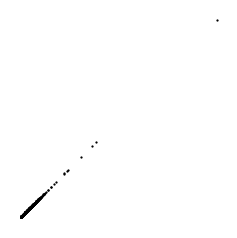

In [9]:
df_test_show=df_test.sample(frac=0.05)
df_pred_show=df_pred.iloc[df_test_show.index]

for sp in labels:
    x=df_test_show[sp]
    y=df_pred_show[sp]
    plt.scatter(x,y,c='k',s=1.5)
    ax=plt.gca()
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    plt.savefig('scatter_plots/{0}_r2.eps'.format(sp),format='eps',bbox_inches='tight', pad_inches=0)
    
!mkdir figs
!mv *.eps figs

# wireframe plots

In [17]:
from mpl_toolkits import mplot3d
def wireframe_plot(x,y,z,sp):
    ax=plt.axes(projection='3d')
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    # ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    # ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    # ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    #ax.set_axis_off()
    ax.set_xlabel('Z')
    ax.set_ylabel('PV')
    ax.set_zlabel(sp)
    ax.plot_wireframe(x,y,z,color='black')
    #plt.savefig('plots_3D/{0}_wireframe.eps'.format(sp),format='eps',bbox_inches='tight', pad_inches=0)
    plt.savefig('plots_3D/{0}_wireframe.eps'.format(sp),format='eps')

#!rm *.eps

In [50]:
x_vec = x.reshape(x.shape[0]*x.shape[1]).T
y_vec = x.reshape(x.shape[0]*x.shape[1]).T
z_vec = x.reshape(x.shape[0]*x.shape[1]).T

z_vec.T.shape
# test = pd.DataFrame(data=[x_vec,y_vec,z_vec],columns=['Z','PV',sp])
# test.info()
test = np.stack((x_vec,y_vec,z_vec)).T
test.shape


(251001, 3)

## plots from original table

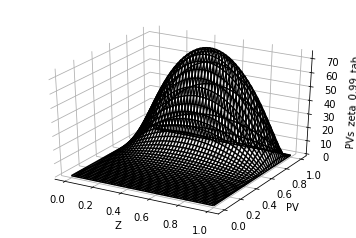

In [53]:
x=df[df.zeta==0]['f'].values
y=df[df.zeta==0]['pv'].values
x=x.reshape(501,-1)
y=y.reshape(501,-1)

for sp in labels:
    for zl in zeta_level:
        z=df[df.zeta==zl][sp].values
        z=z.reshape(501,-1)
        #wireframe_plot(x,y,z,'{0}_zeta_{1}_tab'.format(sp,zl))
        
        # write data array for surf plots
        if zl == 0.0:
            x_vec = x.reshape(x.shape[0]*x.shape[1])
            y_vec = y.reshape(x.shape[0]*x.shape[1])
            z_vec = z.reshape(x.shape[0]*x.shape[1])
            data_np = np.stack((x_vec,y_vec,z_vec)).T
            data_df = pd.DataFrame(data_np,columns=['Z','PV',sp]).sample(5000)
            data_df.to_csv('plots_3D/Surf_%s_TAB.csv' % sp)

## plots form DNN

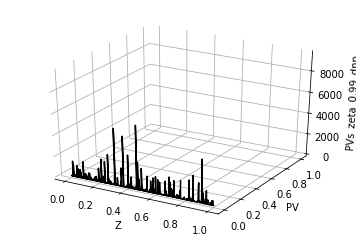

In [54]:
dnn_val = model.predict(x_input,batch_size=1024*8)
dnn_df = pd.DataFrame(out_scaler.inverse_transform(predict_val), columns=labels)

df_dnn=pd.concat([df[input_features],dnn_df],axis=1)
# df_dnn.head(5)

df_dnn df_pred

for sp in labels:
    for zl in zeta_level:
        z=df_dnn[df_dnn.zeta==zl][sp].values
        z=z.reshape(501,-1)
        wireframe_plot(x,y,z,'{0}_zeta_{1}_dnn'.format(sp,zl))
        
        if zl == 0.0:
            x_vec = x.reshape(x.shape[0]*x.shape[1])
            y_vec = y.reshape(x.shape[0]*x.shape[1])
            z_vec = z.reshape(x.shape[0]*x.shape[1])
            data_np = np.stack((x_vec,y_vec,z_vec)).T
            data_df = pd.DataFrame(data_np,columns=['Z','PV',sp]).sample(5000)
            data_df.to_csv('plots_3D/Surf_%s_DNN.csv' % sp)

In [79]:
dnn_val = model.predict(x_input)



## plots of difference

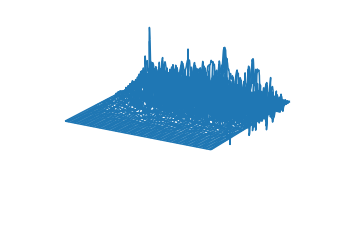

In [207]:
for sp in labels:
    for zl in zeta_level:
        z=df_dnn[df_dnn.zeta==zl][sp].values - df[df.zeta==zl][sp].values
        z=z.reshape(501,-1)
        wireframe_plot(x,y,z,'{0}_zeta_{1}_diff'.format(sp,zl))
        
        if zl == 0.0:
            x_vec = x.reshape(x.shape[0]*x.shape[1])
            y_vec = y.reshape(x.shape[0]*x.shape[1])
            z_vec = z.reshape(x.shape[0]*x.shape[1])
            data_np = np.stack((x_vec,y_vec,z_vec)).T
            data_df = pd.DataFrame(data_np,columns=['Z','PV',sp])
            data_df.to_csv('plots_3D/Surf_%s_DNN.csv' % sp)

In [208]:
!mv *.eps figs